# Numbers With Wings: The Modern Data Stack.

With apologies to [The Bongos](https://www.youtube.com/watch?v=XdPNmHJNQpc)

Suppose you want a dashboard that is automatically kept up to date when new data is available.

For instance, every January 1, I have some notebooks and blog posts I should update with 2022 data, although I usually don't. It would be nice to have that all happen automatically.

We need ~6 things to run data pipelines:

1. A scheduler / orchestrator to check for new data and trigger jobs when data is available: maybe on a schedule, maybe monitoring a local directory, maybe polling a remote directory, maybe receiving emails or other signals.

2. Tools to manage dependency graphs ([DAGs](https://en.wikipedia.org/wiki/Directed_acyclic_graph)) to trigger jobs like db build, data quality, ML training, inference, notifications downstream when jobs succeed or fail.

3. Tools to fetch data from REST APIs, CSVs etc via standard protocols. Built-in schemas for e.g. Zoom or Salesforce would be nice.

4. Tools to munge data, extract, load, and transform (ELT). footnote: Earlier OLAP manifestations processed data into cubes, sort of like spreadsheets within a database, to batch pre-process aggregations and enable real-time drilldowns. Modern data stacks keep data in close to raw form and leverage parallel processing to transform on the fly. In the extreme (i.e. Spark), we can make a cluster and move a shard of the data to each node in the cluster, moving the data close to the compute and keeping it in RAM. Then each node can do its part of aggregations and drilldowns and send the results to a controller for final compilations, [MapReduce](https://en.wikipedia.org/wiki/MapReduce) paradigm style. Thus ELT in contrast to old-school ETL.

footnote 2: Are clusters dead? Threadripper changes everything. When Google first came out, the part that truly blew my mind was not the bigger index and better relevance, but the fact that when you ran a search, the results gave not just a URL, but *the excerpt on the page* that matched your search. *Google was caching the entire Web in RAM*. In less than a second, it farmed out your search to dozens of PCs, each of which kept a shard of the database in RAM, got the results from each shard, sorted them and assembled them into a SERP. Google clusters were an unprecedented new paradigm in computing. To make this work, Google built its own ultra-cheap single-thread servers that were just boards zip-tied together. Today the pendulum has swung the other way. It's *cheaper* to run a giant [AMD Epyc box](https://aws.amazon.com/blogs/aws/new-amazon-ec2-c6a-instances-powered-by-3rd-gen-amd-epyc-processors-for-compute-intensive-workloads/) with 192 cores than equivalent compute on individual servers. Big data, in the sense of data too big to fit on a single box in RAM, hardly exists. This also changes the way software is built, for super high performance services you may want to [pin each thread to a core](https://twitter.com/alexxubyte/status/1588203762945884160), keep everything in on-CPU cache, and never context-switch  . As Moore's law dies, it's more about giant dies for a system-on-a-chip, and in our case a modern data stack-in-a-box, as opposed to clusters. For a lot of apps, vertical is the new horizontal.

5. Data storage to manage the data and let us query it and aggregate it: DBMS, data warehouse, data lake, lakehouse etc.

6. Front end frameworks to create dataviz, reports, dashboards and end-user apps

It might be simpler to break down into ELT, data warehouse, BI/front end. In practice 1, 2, and 3 can overlap but there are usually multiple products. There are also [additional pieces](https://i.redd.it/pdnuk1r0yjf71.jpg), like [monitoring pipelines](https://www.acceldata.io/article/what-is-data-pipeline-monitoring) in production, [data quality](https://greatexpectations.io/), [data governance](https://www.collibra.com/us/en/products/data-governance). You can go [pretty deep](https://mattturck.wpenginepowered.com/wp-content/uploads/2021/12/2021-MAD-Landscape-v3.pdf). But this is a reasonable starting framework.
 
Here we'll try to build a basic modern data stack with [MTA turnstile source data](https://data.ny.gov/Transportation/Turnstile-Usage-Data-2020/py8k-a8wg) to do something like [this](https://toddwschneider.com/dashboards/nyc-subway-turnstiles/) or [this](https://www.subwayridership.nyc/) using:

One way is an enterprise-ish 'on-prem' approach (probably in private or public cloud these days):
- Spark cluster 
- Airflow, dbt, Fivetran, Stitch, Airbyte to manage the data pipeline
- PowerBI, Tableau, Superset to deliver some dashboards
- Django, Appsmith to deliver some apps, with Postgres storage 

another approach is to go 'cloud-native', using pay-as-you-go SaaS cloud services
- Cloud lakehouse like Snowflake or Databricks
- Cloud pipeline services like Prefect, Dagster, Astronomer, dbt Cloud
- Cloud analytics service, Tableau Cloud, PowerBI SaaS, Preset
- Retool, Appsmith Cloud, with hosted Postgres

This cloud-native stack or some variation has major potential to be an extinction-level event for a lot of devs and on-prem/AWS engineers and MSPs. It seems like a good choice for a lot of SMBs. Run everything with SaaS like Salesforce, Square, NetSuite, Workday, Mailchimp, Twilio, Zoom. When you want to build a workflow app to organize a conference, create some Zoom meetings, get paid, send some emails and text messages, build it in Retool to talk to all those SaaS services. 

But I'm not going to do any of those, just want a lightweight stack to run on my MacBook or in a container for a data stack-in-a-box. Tech we will leverage:

- [Duckdb](https://duckdb.org/) is like SQLlite, but for column-oriented data; it's a lightweight package that does high-performance multithreaded aggregation using SQL. [Columnar databases are faster for OLAP](https://loonytek.com/2017/05/04/why-analytic-workloads-are-faster-on-columnar-databases/) . For instance, we can usually get orders of magnitude improvement in size/speed using a columnar format like Parquet vs. CSV with binary storage and compression.

- [Singer](https://www.singer.io/), an open source project from Stitch, lets us build 'taps' that abstract talking to specific data sources, like CSVs, or Salesforce, or Zoom, or Postgres. So with a config file, we can say, grab data from a CSV, or the Web, or a REST API, load it into DuckDB.

- [Meltano](https://meltano.com), an open source project from Gitlab, is a CLI library that uses Singer taps to move data.

- [dbt](https://www.getdbt.com/blog/future-of-the-modern-data-stack/), the database build tool. From your data warehouse's perspective, it's simply a SQL client. But when you write your SQL scripts within the dbt framework, you get almost for free: integration of scripts into an Airflow DAG workflow; logging; self-documentation of every table'S provenance; ability to point any script to dev / test / production environments. 

- [Superset](https://superset.apache.org) is an open source version of Tableau or PowerBI to run a dashboard.

There are [a lot of ways](https://www.moderndatastack.xyz/stacks) to skin this cat. This dude even has a ['post-modern' data stack](https://blog.devgenius.io/modern-data-stack-demo-5d75dcdfba50).

footnote: part of me feels like, if you're a relational database, you had one job, provide a robust, performant abstraction to tabular data. It's annoying to have to use a totally different RDBMS engine for column-oriented vs row-oriented. SQL Server has had COLUMNSTORE for 10 years, even if big data folks don't consider it a true data warehouse. Maybe the traditional RDBMS will incorporate better column-oriented functionality and keep all the good stuff like transactions and query optimization. Or maybe everyone will have to query a [plethora of database engines](https://db-engines.com/en/ranking) and data lakes and we'll need a SQL layer on top of them all (losing the notion of transactions and complicating our lives). Possibly that's the niche that tools like [Trino](https://trino.io/) are looking to fill. Data seems like the mother of all leaky abstractions, you don't get good performance if you don't know a fair amount about what's going on under the hood. DBAs and data engineers are maybe not going away. Or maybe it's so hard that a lot of people will just put the data into managed cloud services optimized for their use case.


In [1]:
from datetime import date, timedelta
from time import strftime
from os import listdir, system
import pickle
import requests
from pathlib import Path
 
import pandas as pd
# modin uses multithreading but doesn't play well with sql magic
# import modin.pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

import sqlalchemy

import duckdb

# Import ipython-sql Jupyter extension to create SQL cells
%load_ext sql
# directly output data to Pandas and to simplify the output that is printed to the notebook.
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

pd.options.display.max_rows=100


# Connect ipython-sql to DuckDB using a SQLAlchemy-style connection string. You may either connect to an in memory DuckDB, or a file backed db.
%sql duckdb:///mta.db


- [Data overview](https://data.ny.gov/api/views/py8k-a8wg/files/535bc30e-4119-4992-a799-65d1a05849d4?download=true&filename=MTA_Turnstile_Data_Overview.pdf)
- [Data dictionary](https://data.ny.gov/api/views/py8k-a8wg/files/5c602688-3031-4f39-8f2b-d4a3cd8c3752?download=true&filename=MTA_Turnstile_Data_DataDictionary.pdf)
- [List of stations](http://web.mta.info/developers/data/nyct/subway/Stations.csv)
- [Alt station list](https://data.cityofnewyork.us/api/views/kk4q-3rt2/rows.csv)
- [Things to watch out for while working with the MTA turnstile data in 2022](https://towardsai.net/p/l/things-to-watch-out-for-while-working-with-the-mta-turnstile-data-in-2022#:~:text=Additionally%2C%20there%20may%20be%20a,missed%20audit%20that%20was%20recovered.)
- [Taming the MTA's unruly turnstile data](https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0)
- [Todd Schneider repo](https://github.com/toddwschneider/nyc-subway-turnstile-data)
- [Sonny Ng project](https://www.subwayridership.nyc/)


# Fetch data

In [2]:
# fetch raw data files
# for any missing saturday after start_date and before today
    
downloaddir = "downloads"
csvdir = "csv"
prefix = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_"
suffix = ".txt"
start_date = date(2019, 1, 7) # start with 1st full week of 2019
end_date = date.today()
delta = end_date - start_date   # returns timedelta

alldays = [start_date + timedelta(days=i) for i in range(delta.days + 1)]
alldays = [day for day in alldays if day.weekday() == 5]

for d in alldays:
    inix=strftime("%y%m%d", d.timetuple())
    url = "%s%s%s" % (prefix, inix, suffix)
    src = "%s/%s%s" % (downloaddir, inix, suffix)
    
    if Path(src).is_file():
        continue
    
    cmd = "curl %s > %s" % (url, src)
    print(cmd)
    system(cmd)
    


In [3]:
datadir = "downloads"
datafiles = sorted(["downloads/" + f for f in listdir(datadir) if f[-4:]==".txt"])
print(datafiles[:3])
print(datafiles[-3:])


['downloads/190112.txt', 'downloads/190119.txt', 'downloads/190126.txt']
['downloads/221217.txt', 'downloads/221224.txt', 'downloads/221231.txt']


In [4]:
# could use cut or otherwise count rows and make sure all loaded
!wc downloads/*

  207557  458128 27189967 downloads/#220319.txt#
      14      18     650 downloads/#lsdjkf#
     218    1267    9883 downloads/#x.csv#
  201091  443694 26342921 downloads/190112.txt
  204728  451584 26819368 downloads/190119.txt
  201600  444615 26409600 downloads/190126.txt
  202913  446998 26581603 downloads/190202.txt
  202736  446746 26558416 downloads/190209.txt
  204738  451369 26820678 downloads/190216.txt
  204056  450373 26731336 downloads/190223.txt
  203190  447711 26617890 downloads/190302.txt
  203988  450481 26722428 downloads/190309.txt
  201793  443970 26434883 downloads/190316.txt
  202723  446742 26556713 downloads/190323.txt
  204596  450356 26802076 downloads/190330.txt
  202965  446721 26588415 downloads/190406.txt
  204712  450741 26817272 downloads/190413.txt
  202548  446568 26533788 downloads/190420.txt
  203858  449132 26705398 downloads/190427.txt
  206858  455245 27098398 downloads/190504.txt
  204089  449247 26735659 downloads/190511.txt
  208682  460970 2

  211267  466379 27675977 downloads/220430.txt
  211174  465807 27663794 downloads/220507.txt
  211017  466542 27643227 downloads/220514.txt
  210476  464233 27572356 downloads/220521.txt
  211708  466712 27733748 downloads/220528.txt
  211610  467320 27720910 downloads/220604.txt
  211248  466701 27673488 downloads/220611.txt
  211154  465829 27661174 downloads/220618.txt
  212413  468989 27826103 downloads/220625.txt
  211264  466005 27675584 downloads/220702.txt
  210933  465747 27632223 downloads/220709.txt
  210933  465747 27632223 downloads/220716.txt
  210230  464601 27540130 downloads/220723.txt
  210656  465419 27595936 downloads/220730.txt
  210959  465602 27635629 downloads/220806.txt
  211950  468990 27765450 downloads/220813.txt
  210600  464869 27588600 downloads/220820.txt
  211048  466789 27647288 downloads/220827.txt
  212449  469554 27830819 downloads/220903.txt
  212391  469334 27823221 downloads/220910.txt
  210699  465093 27601569 downloads/220917.txt
  210592  464

# Load & initial cleanup with DuckDB

In [5]:
# load into mta.db
print ("%s Starting DuckDB initial load" % (strftime("%H:%M:%S")))

15:29:04 Starting DuckDB initial load


In [6]:
%%sql

drop table if exists mta;
drop table if exists temp_data;

create table temp_data(
    "C/A" VARCHAR, 
    UNIT VARCHAR, 
    SCP VARCHAR, 
    STATION VARCHAR, 
    LINENAME VARCHAR, 
    DIVISION VARCHAR, 
    DATE DATE, 
    TIME TIME, 
    "DESC" VARCHAR, 
    ENTRY_COUNTER INTEGER, 
    EXIT_COUNTER INTEGER);


""


In [7]:
datadir = "downloads"
datafiles = sorted([datadir + "/" + f for f in listdir(datadir) if f[-4:]==".txt"])

for f in datafiles:
    print(f)
    %sql insert into temp_data SELECT * FROM read_csv(:f, \
                                                      delim=',', \
                                                      header=True, \
                                                      columns={'C/A': 'VARCHAR', \
                                                               'UNIT': 'VARCHAR', \
                                                               'SCP': 'VARCHAR', \
                                                               'STATION': 'VARCHAR', \
                                                               'LINENAME': 'VARCHAR', \
                                                               'DIVISION': 'VARCHAR', \
                                                               'DATE': 'DATE', \
                                                               'TIME': 'TIME',\
                                                               'DESC': 'VARCHAR',\
                                                               'ENTRIES': 'INTEGER',\
                                                               'EXITS': 'INTEGER',},\
                                                      dateformat='%m/%d/%Y');
    
    

downloads/190112.txt
downloads/190119.txt
downloads/190126.txt
downloads/190202.txt
downloads/190209.txt
downloads/190216.txt
downloads/190223.txt
downloads/190302.txt
downloads/190309.txt
downloads/190316.txt
downloads/190323.txt
downloads/190330.txt
downloads/190406.txt
downloads/190413.txt
downloads/190420.txt
downloads/190427.txt
downloads/190504.txt
downloads/190511.txt
downloads/190518.txt
downloads/190525.txt
downloads/190601.txt
downloads/190608.txt
downloads/190615.txt
downloads/190622.txt
downloads/190629.txt
downloads/190706.txt
downloads/190713.txt
downloads/190720.txt
downloads/190727.txt
downloads/190803.txt
downloads/190810.txt
downloads/190817.txt
downloads/190824.txt
downloads/190831.txt
downloads/190907.txt
downloads/190914.txt
downloads/190921.txt
downloads/190928.txt
downloads/191005.txt
downloads/191012.txt
downloads/191019.txt
downloads/191026.txt
downloads/191102.txt
downloads/191109.txt
downloads/191116.txt
downloads/191123.txt
downloads/191130.txt
downloads/191

In [8]:
%sql SELECT COUNT(*) FROM temp_data


,count_star()
0,43361148


In [9]:
%%sql
select * from temp_data limit 10;

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,time,DESC,ENTRY_COUNTER,EXIT_COUNTER
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-05,03:00:00,REGULAR,6897012,2338472
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-05,07:00:00,REGULAR,6897023,2338487
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-05,11:00:00,REGULAR,6897083,2338565
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-05,15:00:00,REGULAR,6897262,2338624
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-05,19:00:00,REGULAR,6897572,2338679
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-05,23:00:00,REGULAR,6897740,2338703
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-06,03:00:00,REGULAR,6897782,2338707
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-06,07:00:00,REGULAR,6897793,2338714
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-06,11:00:00,REGULAR,6897854,2338762
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-01-06,15:00:00,REGULAR,6898015,2338818


In [10]:
# deduplicate rows
%sql drop table if exists mta;
%sql create table mta as SELECT distinct * FROM "temp_data" ;
%sql drop table temp_data;
%sql SELECT COUNT(*) FROM mta


,count_star()
0,43150216


In [11]:
# remove these audit records ... might need to check if they should always be deleted
%sql delete from mta where "DESC" = 'RECOVR AUD';
%sql SELECT COUNT(*) FROM mta


,count_star()
0,42956693


In [12]:
# add timestamp from date/time
%sql alter table mta add column DATE_TIME timestamp;
%sql update mta set DATE_TIME = make_timestamp(date_part('year', date), date_part('month', date), date_part('day', date),date_part('hour', TIME), date_part('minute', TIME), date_part('second', TIME))



,Count
0,42956693


In [13]:
# make unique turnstile labels
%sql alter table mta add column TURNSTILE VARCHAR;
%sql update mta set TURNSTILE = CONCAT("C/A" , ' ' , UNIT , ' ' , SCP)


,Count
0,42956693


In [14]:
# make unique station names, else you have '7 AV' in Manhattan, Brooklyn, multiple "23 St" etc
%sql update mta set station = concat(station, '-', linename);


,Count
0,42956693


In [15]:
# fix some issues with same station having multiple names
# in ideal world would cross-reference MTA station list
fixes = {
    '14 ST-UNION SQ-LNQR456W': '14 ST-UNION SQ-456LNQRW',
    '161/YANKEE STAD-BD4': '161/YANKEE STAD-4BD',
    '34 ST-PENN STA-123': '34 ST-PENN STA-123ACE',
    '34 ST-PENN STA-ACE': '34 ST-PENN STA-123ACE',
    '42 ST-PORT AUTH-ACENGRS1237W': '42 ST-PORT AUTH-ACENQRS1237W',
    '59 ST-NQR456W': '59 ST-456NQRW',
    '59 ST-NRW': '59 ST-456NQRW',
    '59 ST COLUMBUS-ABCD1': '59 ST COLUMBUS-1ABCD',
    'ATL AV-BARCLAY-BDNQR2345': 'ATL AV-BARCLAY-2345BDNQR',
    'BOROUGH HALL-R2345': 'BOROUGH HALL-2345R',
    'COURT SQ-23 ST-EMG': 'COURT SQ-EMG',
    'FULTON ST-ACJZ2345': 'FULTON ST-2345ACJZ',
    'GUN HILL RD-5': 'GUN HILL RD-25',
    'PATH WTC 2-PTH-1': 'PATH NEW WTC-PTH-1',
    'PELHAM PKWY-5': 'PELHAM PKWY-25',
}


for k, v in fixes.items():
    print(k, '->', v)
    %sql update mta set station = :v where station = :k;


14 ST-UNION SQ-LNQR456W -> 14 ST-UNION SQ-456LNQRW
161/YANKEE STAD-BD4 -> 161/YANKEE STAD-4BD
34 ST-PENN STA-123 -> 34 ST-PENN STA-123ACE
34 ST-PENN STA-ACE -> 34 ST-PENN STA-123ACE
42 ST-PORT AUTH-ACENGRS1237W -> 42 ST-PORT AUTH-ACENQRS1237W
59 ST-NQR456W -> 59 ST-456NQRW
59 ST-NRW -> 59 ST-456NQRW
59 ST COLUMBUS-ABCD1 -> 59 ST COLUMBUS-1ABCD
ATL AV-BARCLAY-BDNQR2345 -> ATL AV-BARCLAY-2345BDNQR
BOROUGH HALL-R2345 -> BOROUGH HALL-2345R
COURT SQ-23 ST-EMG -> COURT SQ-EMG
FULTON ST-ACJZ2345 -> FULTON ST-2345ACJZ
GUN HILL RD-5 -> GUN HILL RD-25
PATH WTC 2-PTH-1 -> PATH NEW WTC-PTH-1
PELHAM PKWY-5 -> PELHAM PKWY-25


In [16]:
%sql SELECT station, count(*) FROM mta group by station order by station;


,STATION,count_star()
0,1 AV-L,167169
1,103 ST-1,52277
2,103 ST-6,53182
3,103 ST-BC,26353
4,103 ST-CORONA-7,78419
...,...,...
460,WOODLAWN-4,43498
461,WORLD TRADE CTR-ACE23,154998
462,WTC-CORTLANDT-1,303231
463,YORK ST-F,26119


In [17]:
# not sure why %sql magic sometimes doesn't work here  
con = duckdb.connect('mta.db')
query = "SELECT station, count(*) FROM mta group by station order by station;"
con.execute(query)
con.fetchall()


[('1 AV-L', 167169),
 ('103 ST-1', 52277),
 ('103 ST-6', 53182),
 ('103 ST-BC', 26353),
 ('103 ST-CORONA-7', 78419),
 ('104 ST-A', 43443),
 ('104 ST-JZ', 34830),
 ('110 ST-6', 52331),
 ('111 ST-7', 43438),
 ('111 ST-A', 59758),
 ('111 ST-J', 31110),
 ('116 ST-23', 69021),
 ('116 ST-6', 69564),
 ('116 ST-BC', 52062),
 ('116 ST-COLUMBIA-1', 52016),
 ('121 ST-JZ', 51966),
 ('125 ST-1', 43381),
 ('125 ST-23', 69471),
 ('125 ST-456', 121258),
 ('125 ST-ACBD', 138149),
 ('135 ST-23', 103965),
 ('135 ST-BC', 94768),
 ('137 ST CITY COL-1', 86891),
 ('138/GRAND CONC-45', 25968),
 ('14 ST-123FLM', 130795),
 ('14 ST-ACEL', 115612),
 ('14 ST-FLM123', 187929),
 ('14 ST-UNION SQ-456LNQRW', 353925),
 ('145 ST-1', 60368),
 ('145 ST-3', 34477),
 ('145 ST-ABCD', 77617),
 ('149/GRAND CONC-245', 60429),
 ('14TH STREET-1', 88837),
 ('15 ST-PROSPECT-FG', 104202),
 ('155 ST-BD', 26136),
 ('155 ST-C', 43591),
 ('157 ST-1', 69338),
 ('161/YANKEE STAD-4BD', 317384),
 ('163 ST-AMSTERDM-C', 69570),
 ('167 ST-4', 

In [18]:
%%sql
ALTER TABLE mta DROP LINENAME;
ALTER TABLE mta DROP DIVISION;
ALTER TABLE mta DROP "DESC";
ALTER TABLE mta DROP TIME;
ALTER TABLE mta DROP "C/A";
ALTER TABLE mta DROP UNIT;
ALTER TABLE mta DROP SCP;


""


In [19]:
%%sql
describe mta

,column_name,column_type,null,key,default,extra
0,STATION,VARCHAR,YES,None,None,None
1,DATE,DATE,YES,None,None,None
2,ENTRY_COUNTER,INTEGER,YES,None,None,None
3,EXIT_COUNTER,INTEGER,YES,None,None,None
4,DATE_TIME,TIMESTAMP,YES,None,None,None
5,TURNSTILE,VARCHAR,YES,None,None,None


In [20]:
%%sql
PRAGMA database_size;

,database_size,block_size,total_blocks,used_blocks,free_blocks,wal_size,memory_usage,memory_limit
0,8.9GB,262144,34093,26448,7645,272 bytes,3.7GB,27.4GB


In [21]:
# query = "PRAGMA database_size;"
# con.execute(query)
# con.fetchall()


In [22]:
print ("%s Ending DuckDB initial load" % (strftime("%H:%M:%S")))


15:35:31 Ending DuckDB initial load


# Data quality with DuckDB

- check if each turnstile is available for each station for each time, compute % time coverage vs. expected
- check any overlapping time periods by turnstile 
- compute change in entries, exits by turnstile by time
- fix negatives
- fix outliers, usually indicate maintenance reset count 

Should review articles and Todd Schneider code for additional data quality checks and fixes. Could possibly add better data quality with

- https://greatexpectations.io/
- https://pandera.readthedocs.io/en/stable/
- https://github.com/awslabs/python-deequ
    

## Compute diffs

In [23]:
print ("%s Starting diff and DQ" % (strftime("%H:%M:%S")))


15:35:31 Starting diff and DQ


In [24]:
%%sql
drop table if exists mta_diff;

CREATE TABLE mta_diff AS 
SELECT DATE, DATE_TIME, STATION, TURNSTILE, 
ENTRY_COUNTER,
ENTRY_COUNTER - lag(ENTRY_COUNTER) OVER (PARTITION BY STATION, TURNSTILE ORDER BY DATE_TIME) AS ENTRIES,
2000 ENTRIES_CUTOFF ,
EXIT_COUNTER,
EXIT_COUNTER - lag(EXIT_COUNTER) OVER (PARTITION BY STATION, TURNSTILE ORDER BY DATE_TIME) AS EXITS,
2000 EXITS_CUTOFF
FROM mta;


,Count
0,42956693


In [25]:
%sql describe mta_diff;

,column_name,column_type,null,key,default,extra
0,DATE,DATE,YES,None,None,None
1,DATE_TIME,TIMESTAMP,YES,None,None,None
2,STATION,VARCHAR,YES,None,None,None
3,TURNSTILE,VARCHAR,YES,None,None,None
4,ENTRY_COUNTER,INTEGER,YES,None,None,None
5,ENTRIES,INTEGER,YES,None,None,None
6,ENTRIES_CUTOFF,INTEGER,YES,None,None,None
7,EXIT_COUNTER,INTEGER,YES,None,None,None
8,EXITS,INTEGER,YES,None,None,None
9,EXITS_CUTOFF,INTEGER,YES,None,None,None


In [26]:
%sql select * from mta_diff order by station, turnstile, date_time limit 100;

,DATE,DATE_TIME,STATION,TURNSTILE,ENTRY_COUNTER,ENTRIES,ENTRIES_CUTOFF,EXIT_COUNTER,EXITS,EXITS_CUTOFF
0,2019-01-05,2019-01-05 03:00:00,1 AV-L,H007 R248 00-00-00,14289362,NaN,2000,16019507,NaN,2000
1,2019-01-05,2019-01-05 07:00:00,1 AV-L,H007 R248 00-00-00,14289390,28.0,2000,16019637,130.0,2000
2,2019-01-05,2019-01-05 11:00:00,1 AV-L,H007 R248 00-00-00,14289676,286.0,2000,16020202,565.0,2000
3,2019-01-05,2019-01-05 15:00:00,1 AV-L,H007 R248 00-00-00,14290302,626.0,2000,16021021,819.0,2000
4,2019-01-05,2019-01-05 19:00:00,1 AV-L,H007 R248 00-00-00,14291008,706.0,2000,16021960,939.0,2000
5,2019-01-05,2019-01-05 23:00:00,1 AV-L,H007 R248 00-00-00,14291511,503.0,2000,16022688,728.0,2000
6,2019-01-06,2019-01-06 03:00:00,1 AV-L,H007 R248 00-00-00,14291682,171.0,2000,16022932,244.0,2000
7,2019-01-06,2019-01-06 07:00:00,1 AV-L,H007 R248 00-00-00,14291703,21.0,2000,16023046,114.0,2000
8,2019-01-06,2019-01-06 11:00:00,1 AV-L,H007 R248 00-00-00,14291913,210.0,2000,16023463,417.0,2000
9,2019-01-06,2019-01-06 15:00:00,1 AV-L,H007 R248 00-00-00,14292465,552.0,2000,16024360,897.0,2000


In [27]:
%sql drop table mta;

""


In [28]:
%sql ALTER TABLE mta_diff drop column ENTRY_COUNTER;
%sql ALTER TABLE mta_diff drop column EXIT_COUNTER;
%sql ALTER TABLE mta_diff RENAME TO mta;


""


### Check for dupes

In [29]:
%%sql 

select DATE_TIME, STATION, TURNSTILE, count(*) from mta
group by DATE_TIME, STATION, TURNSTILE
having count(*) > 1;


""


## fix <=0, sometimes maintenance is done, resets turnstile counter


In [30]:
%%sql
describe mta

,column_name,column_type,null,key,default,extra
0,DATE,DATE,YES,None,None,None
1,DATE_TIME,TIMESTAMP,YES,None,None,None
2,STATION,VARCHAR,YES,None,None,None
3,TURNSTILE,VARCHAR,YES,None,None,None
4,ENTRIES,INTEGER,YES,None,None,None
5,ENTRIES_CUTOFF,INTEGER,YES,None,None,None
6,EXITS,INTEGER,YES,None,None,None
7,EXITS_CUTOFF,INTEGER,YES,None,None,None


In [31]:
# delete rows at start of window with no diff

In [32]:
%%sql
delete from mta
where entries is null 
and exits is null;


,Count
0,5243


In [33]:
%%sql
select count(*) from mta where ENTRIES < 0;


,count_star()
0,381150


In [34]:
%%sql
select count(*) from mta where EXITS < 0;


,count_star()
0,274046


In [35]:
%%sql
delete from mta where ENTRIES < 0;


,Count
0,381150


In [36]:
%%sql
delete from mta where EXITS < 0;


,Count
0,109753


## Dropping bad rows

- Taking a slightly more permissive approach than cutting off everything > 2K
- Looking at e.g. BEDFORD AV-L	H009	R235	00-03-04 , does 2000 on the regular
- First cut off everything > 6K. Every 2s = 7200 in 4h period. but I wonder if sometimes the period is longer? I could see a deal at a massive event where trains keep coming and there is always a queue at a turnstile
- Then compute average, sd, count by turnstile
- if count < 20 then cut off everything > 2K
- if count >= 20 then cut off everything based on SD, with a 1K minmimum threshold
- Seems to call for some kind of bayesian approach, maybe use one of the DQ packages
    - for each new turnstile start with a prior distribution on the turnstile mean and sd based on all the turnstiles
    - for each observation at that turnstile, update the prior
    - at the end , discard the observations that are eg 4 updated sds from the updated mean. (we should think about what sort of true distribution there is, how many we will discard, what the tradeoff is for rejecting a row incorrectly).
    - so if you only have 1 observation, you'll be discarding based on close to the population mean and sd
    - if you have 30 observations, you'll be discarding based on close to the turnstile mean and sd
    - also if there was turnstile maintenance both entries and exits should be off, can add signal and reduce sd threshold and require both to be off (not doing this)
     - IMO it's pretty easy for something weird to happen where something goes to a different mode, flood or cops or something closes an entrance, 1-time big event. Seems like a good DQ framework needs a flexible rule plus some whitelisted days/exceptions.

## Hard 7200 limit per turnstile per period


In [37]:
%%sql
select count(*) from mta where ENTRIES > 7200;


,count_star()
0,1430


In [38]:
%%sql
select count(*) from mta where EXITS > 7200;


,count_star()
0,1859


In [39]:
%%sql
delete from mta where ENTRIES>7200;
delete from mta where EXITS>7200;


,Count
0,850


## Compute average, sd, observation count by turnstile

In [40]:
%%sql 
drop table if exists entry_avg;
create table entry_avg as 
select station, TURNSTILE, avg(entries) MEAN, stddev(entries) SD, count(*) N, 
from mta
where entries > 0
group by station, TURNSTILE;


,Count
0,4897


In [41]:
%%sql 
select * from entry_avg order by MEAN desc limit 100;

,STATION,TURNSTILE,MEAN,SD,N
0,NEWARK HM HE-1,PTH20 R549 03-00-08,2291.250000,3290.251903,4
1,CHRISTOPHER ST-1,PTH09 R548 00-00-08,1465.250000,1197.894368,4
2,NEWARK BM BW-1,PTH18 R549 01-02-08,1264.600000,2140.606526,5
3,34 ST-HERALD SQ-BDFMNQRW,N507 R023 00-06-00,811.500000,1078.337841,2
4,BEDFORD AV-L,H009 R235 00-03-04,811.250679,583.046615,2577
5,14 ST-ACEL,N078 R175 01-06-03,656.710124,720.385211,1373
6,TIMES SQ-42 ST-1237ACENQRSW,R148 R033 01-06-00,535.794322,548.857295,1726
7,34 ST-HERALD SQ-BDFMNQRW,N506 R022 00-05-03,494.966372,418.224162,2260
8,59 ST COLUMBUS-1ABCD,N051 R084 02-00-00,493.866113,517.289327,8664
9,WOODHAVEN BLVD-MR,N329A R201 01-06-00,487.353977,361.778601,1647


In [42]:
%%sql
select * from entry_avg where turnstile ='N078 R175 01-06-00'
limit 100;

,STATION,TURNSTILE,MEAN,SD,N
0,14 ST-ACEL,N078 R175 01-06-00,49.121103,67.805787,8084


In [43]:
%%sql
select * from mta
where turnstile ='N078 R175 01-06-00'
order by entries desc limit 100;

,DATE,DATE_TIME,STATION,TURNSTILE,ENTRIES,ENTRIES_CUTOFF,EXITS,EXITS_CUTOFF
0,2022-07-09,2022-07-09 01:00:00,14 ST-ACEL,N078 R175 01-06-00,902,2000,1060,2000
1,2019-02-07,2019-02-07 20:00:00,14 ST-ACEL,N078 R175 01-06-00,535,2000,207,2000
2,2019-10-07,2019-10-07 21:00:00,14 ST-ACEL,N078 R175 01-06-00,478,2000,230,2000
3,2019-12-03,2019-12-03 20:00:00,14 ST-ACEL,N078 R175 01-06-00,388,2000,133,2000
4,2020-01-31,2020-01-31 20:00:00,14 ST-ACEL,N078 R175 01-06-00,381,2000,153,2000
5,2019-03-14,2019-03-14 21:00:00,14 ST-ACEL,N078 R175 01-06-00,374,2000,93,2000
6,2019-12-10,2019-12-10 20:00:00,14 ST-ACEL,N078 R175 01-06-00,371,2000,137,2000
7,2019-01-16,2019-01-16 20:00:00,14 ST-ACEL,N078 R175 01-06-00,370,2000,78,2000
8,2019-01-22,2019-01-22 20:00:00,14 ST-ACEL,N078 R175 01-06-00,368,2000,85,2000
9,2019-01-29,2019-01-29 20:00:00,14 ST-ACEL,N078 R175 01-06-00,366,2000,89,2000


In [44]:
%%sql
alter table entry_avg add column ENTRIES_CUTOFF DOUBLE;
update entry_avg set ENTRIES_CUTOFF = MEAN + 3 * SD;
update entry_avg set ENTRIES_CUTOFF = 2000 where N <= 20;
update entry_avg set ENTRIES_CUTOFF = 2000 where ENTRIES_CUTOFF > 100000;
update entry_avg set ENTRIES_CUTOFF = 2000 where isnan(ENTRIES_CUTOFF);
update entry_avg set ENTRIES_CUTOFF = 2000 where ENTRIES_CUTOFF < 2000;


,Count
0,4831


In [45]:
%%sql
update mta 
set ENTRIES_CUTOFF = (
select ENTRIES_CUTOFF from entry_avg
    where
    entry_avg.station = mta.station and 
    entry_avg.turnstile = mta.turnstile
)
where exists (
    select 1 from entry_avg
    where
    entry_avg.station = mta.station and 
    entry_avg.turnstile = mta.turnstile
)




,Count
0,40470358


In [46]:
%%sql 
drop table if exists exit_avg;
create table exit_avg as 
select station, TURNSTILE, avg(exits) MEAN, stddev(exits) SD, count(*) N, 
from mta
where exits > 0
group by station, TURNSTILE;


,Count
0,4905


In [47]:
%%sql
select * from exit_avg order by MEAN desc limit 100;


,STATION,TURNSTILE,MEAN,SD,N
0,CHRISTOPHER ST-1,PTH09 R548 00-00-08,2571.250000,1849.841682,4
1,NEWARK HM HE-1,PTH20 R549 03-00-08,1698.333333,1809.004491,9
2,34 ST-PENN STA-123ACE,N071 R013 00-05-00,1168.428571,2257.213242,7
3,9TH STREET-1,PTH10 R547 00-00-08,1054.000000,1470.782105,2
4,42 ST-PORT AUTH-ACENQRS1237W,N063A R011 00-00-00,910.563798,931.663145,8762
5,GRD CNTRL-42 ST-4567S,R240 R047 00-00-00,798.264372,933.934949,8541
6,34 ST-PENN STA-123ACE,N071 R013 00-05-01,798.000000,1573.615900,7
7,W 4 ST-WASH SQ-ABCDEFM,N083 R138 01-00-00,764.586417,727.153069,8702
8,86 ST-456,R249 R179 01-00-09,732.635463,661.595930,8685
9,42 ST-PORT AUTH-ACENQRS1237W,N063A R011 00-00-01,674.622319,785.532326,8764


In [48]:
%%sql
select * from mta where turnstile='N012 R035 01-05-01'
order by exits desc limit 100;

,DATE,DATE_TIME,STATION,TURNSTILE,ENTRIES,ENTRIES_CUTOFF,EXITS,EXITS_CUTOFF
0,2022-07-09,2022-07-09 00:00:00,168 ST-AC1,N012 R035 01-05-01,0,2000,50,2000
1,2021-11-07,2021-11-07 15:00:00,168 ST-AC1,N012 R035 01-05-01,0,2000,17,2000
2,2021-03-19,2021-03-19 04:00:00,168 ST-AC1,N012 R035 01-05-01,0,2000,13,2000
3,2022-11-27,2022-11-27 11:00:00,168 ST-AC1,N012 R035 01-05-01,0,2000,12,2000
4,2022-12-02,2022-12-02 15:00:00,168 ST-AC1,N012 R035 01-05-01,0,2000,11,2000
5,2022-07-09,2022-07-09 20:00:00,168 ST-AC1,N012 R035 01-05-01,0,2000,10,2000
6,2022-11-27,2022-11-27 15:00:00,168 ST-AC1,N012 R035 01-05-01,0,2000,10,2000
7,2022-08-22,2022-08-22 00:00:00,168 ST-AC1,N012 R035 01-05-01,0,2000,9,2000
8,2022-11-27,2022-11-27 07:00:00,168 ST-AC1,N012 R035 01-05-01,0,2000,9,2000
9,2022-08-27,2022-08-27 16:00:00,168 ST-AC1,N012 R035 01-05-01,0,2000,8,2000


In [49]:
%%sql
alter table exit_avg add column EXITS_CUTOFF DOUBLE;
update exit_avg set EXITS_CUTOFF = MEAN + 3 * SD;
update exit_avg set EXITS_CUTOFF = 2000 where N <= 20;
update exit_avg set EXITS_CUTOFF = 2000 where EXITS_CUTOFF > 100000;
update exit_avg set EXITS_CUTOFF = 2000 where isnan(EXITS_CUTOFF);
update exit_avg set EXITS_CUTOFF = 2000 where EXITS_CUTOFF < 2000;


,Count
0,4815


In [50]:
%%sql
update mta
set EXITS_CUTOFF = (
select EXITS_CUTOFF from exit_avg
    where
    exit_avg.station = mta.station and 
    exit_avg.turnstile = mta.turnstile 
)
where exists (
    select 1 from exit_avg
    where
    exit_avg.station = mta.station and 
    exit_avg.turnstile = mta.turnstile
)


,Count
0,40435054


In [51]:
print ("%s deleting based on cutoff" % (strftime("%H:%M:%S")))


15:37:36 deleting based on cutoff


In [52]:
# hard cutoff, delete if either exits or entries exceeds. 
# although if a technical issue both entries and exits should be off

In [53]:
%%sql 
delete from mta where entries > entries_cutoff


,Count
0,11554


In [54]:
%%sql
delete from mta where exits > exits_cutoff


,Count
0,15880


In [55]:
%%sql
delete from mta where entries=0 and exits=0;


,Count
0,5316000


In [56]:
print ("%s Finishing diff and DQ" % (strftime("%H:%M:%S")))


15:40:25 Finishing diff and DQ


In [57]:
%%sql
select count(*) from mta

,count_star()
0,37114833


In [58]:
%%sql
describe mta

,column_name,column_type,null,key,default,extra
0,DATE,DATE,YES,None,None,None
1,DATE_TIME,TIMESTAMP,YES,None,None,None
2,STATION,VARCHAR,YES,None,None,None
3,TURNSTILE,VARCHAR,YES,None,None,None
4,ENTRIES,INTEGER,YES,None,None,None
5,ENTRIES_CUTOFF,INTEGER,YES,None,None,None
6,EXITS,INTEGER,YES,None,None,None
7,EXITS_CUTOFF,INTEGER,YES,None,None,None


In [59]:
%%sql
PRAGMA database_size;


,database_size,block_size,total_blocks,used_blocks,free_blocks,wal_size,memory_usage,memory_limit
0,8.9GB,262144,34093,22962,11131,0 bytes,483.3MB,27.4GB


# Aggregate

In [ ]:
print ("%s Starting aggregation and dataviz" % (strftime("%H:%M:%S")))


In [60]:
%%sql

df << select DATE, sum(ENTRIES) ENTRIES
from mta
group by date
order by date;

Returning data to local variable df


In [61]:

df["rolling"] = df['ENTRIES'].rolling(7).sum()/7/1000000
df


,DATE,ENTRIES,rolling
0,2019-01-05,2398947,NaN
1,2019-01-06,2328146,NaN
2,2019-01-07,5261555,NaN
3,2019-01-08,5448763,NaN
4,2019-01-09,5559384,NaN
...,...,...,...
1444,2022-12-26,1191719,1.659326
1445,2022-12-27,1841099,1.583412
1446,2022-12-28,1983999,1.527585
1447,2022-12-29,2030113,1.509685


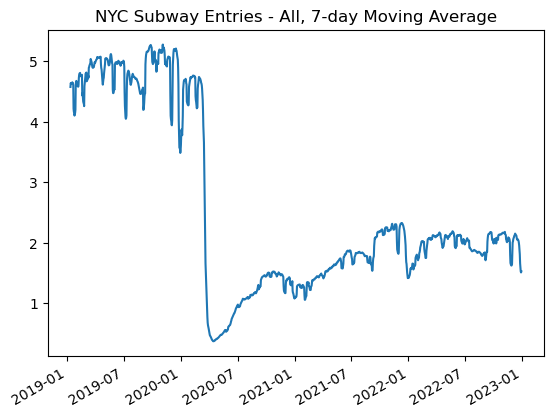

In [62]:
plt.plot(df["DATE"], df["rolling"])
plt.title("NYC Subway Entries - All, 7-day Moving Average")
plt.gcf().autofmt_xdate();


In [63]:
cbd_stations = ['1 AV-L',
'14 ST-123FLM',
'14 ST-ACEL',
'14 ST-UNION SQ-456LNQRW',
'14TH STREET-1',
'18 ST-1',
'2 AV-F',
'23 ST-1',
'23 ST-6',
'23 ST-CE',
'23 ST-FM',
'23 ST-NRW',
'28 ST-1',
'28 ST-6',
'28 ST-NRW',
'3 AV-L',
'33 ST-6',
'34 ST-HERALD SQ-BDFMNQRW',
'34 ST-HUDSON YD-7',
'34 ST-PENN STA-123',
'34 ST-PENN STA-123ACE',
'34 ST-PENN STA-ACE',
'42 ST-BRYANT PK-7BDFM',
'42 ST-PORT AUTH-1237ACEGNRSW',
'42 ST-PORT AUTH-1237ACENQRSW',
'47-50 STS ROCK-BDFM',
'49 ST-NQRW',
'5 AV/53 ST-EM',
'5 AV/59 ST-NQRW',
'5 AVE-7BDFM',
'50 ST-1',
'50 ST-CE',
'50 ST-D',
'51 ST-6',
'57 ST-7 AV-NQRW',
'57 ST-F',
'59 ST COLUMBUS-1ABCD',
'59 ST-456NQRW',
'59 ST-NRW',
'6 AV-123FLM',
'7 AV-BDE',
'8 AV-ACEL',
'8 ST-NYU-NRW',
'9TH STREET-1',
'ASTOR PL-6',
"B'WAY-LAFAYETTE-6BDFQ",
'BLEECKER ST-6DF',
'BOWLING GREEN-45',
'BROAD ST-JZ',
'BROOKLYN BRIDGE-456JZ',
'CANAL ST-1',
'CANAL ST-6JNQRWZ',
'CANAL ST-ACE',
'CHAMBERS ST-123',
'CHAMBERS ST-23ACE',
'CHAMBERS ST-456JZ',
'CHRISTOPHER ST-1',
'CITY HALL-NRW',
'CORTLANDT ST-NRW',
'DELANCEY/ESSEX-FJMZ',
'EAST BROADWAY-F',
'EXCHANGE PLACE-1',
'FRANKLIN ST-1',
'FULTON ST-2345ACJZ',
'GRAND ST-BD',
'GRD CNTRL-42 ST-4567S',
'HOUSTON ST-1',
'LEXINGTON AV/53-6EM',
'LEXINGTON AV/63-F',
'PARK PLACE-23ACE',
'PATH NEW WTC-1',
'PATH WTC 2-1',
'PRINCE ST-NRW',
'RECTOR ST-1',
'RECTOR ST-NRW',
'SOUTH FERRY-1RW',
'SPRING ST-6',
'SPRING ST-CE',
'TIMES SQ-42 ST-1237ACENQRS',
'TIMES SQ-42 ST-1237ACENQRSW',
'TWENTY THIRD ST-1',
'W 4 ST-WASH SQ-ABCDEFM',
'WALL ST-23',
'WALL ST-45',
'WHITEHALL S-FRY-1RW',
'WORLD TRADE CTR-23ACE',
'WTC-CORTLANDT-1',
]


In [64]:
%%sql df << select DATE, STATION, sum(ENTRIES) ENTRIES
from mta
group by DATE, STATION
order by entries desc;

Returning data to local variable df


In [65]:
df

,DATE,STATION,ENTRIES
0,2019-10-03,34 ST-PENN STA-123ACE,184904
1,2019-12-12,34 ST-PENN STA-123ACE,182952
2,2019-12-18,34 ST-PENN STA-123ACE,182520
3,2019-10-25,34 ST-PENN STA-123ACE,181684
4,2019-12-05,34 ST-PENN STA-123ACE,181411
...,...,...,...
670479,2020-01-12,VAN SICLEN AV-JZ,0
670480,2019-10-20,39 AV-NQW,0
670481,2021-05-23,NEPTUNE AV-F,0
670482,2021-10-10,NEPTUNE AV-F,0


In [66]:
# manhattan < 66 st
# before 11am on weekday
cbd_df = df.loc[df["STATION"].isin(cbd_stations)].copy()
len(df)

670484

In [67]:
cbd_df = cbd_df[['DATE', 'ENTRIES']].groupby("DATE") \
    .sum() \
    .reset_index()

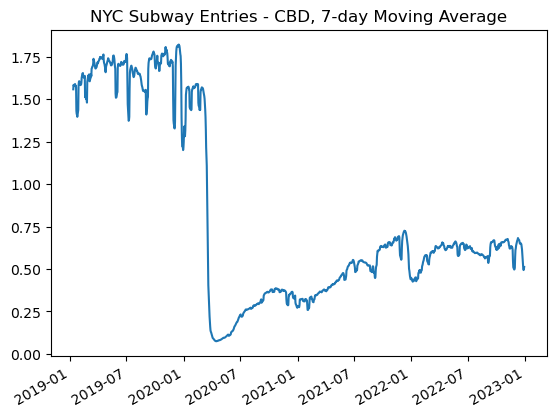

In [68]:
cbd_df["rolling"] = cbd_df['ENTRIES'].rolling(7).sum()/7/1000000

plt.plot(cbd_df["DATE"], cbd_df["rolling"])
plt.title("NYC Subway Entries - CBD, 7-day Moving Average")
plt.gcf().autofmt_xdate();


In [69]:
%%sql
df << select DATE, DATE_TIME, sum(ENTRIES) ENTRIES
from mta
where ENTRIES > 0
group by DATE, DATE_TIME
order by DATE, DATE_TIME;


Returning data to local variable df


In [70]:
df

,DATE,DATE_TIME,ENTRIES
0,2019-01-05,2019-01-05 04:00:00,36341
1,2019-01-05,2019-01-05 04:13:38,29
2,2019-01-05,2019-01-05 04:16:19,4
3,2019-01-05,2019-01-05 04:19:33,11
4,2019-01-05,2019-01-05 04:20:02,18
...,...,...,...
2020763,2022-12-30,2022-12-30 23:52:57,31
2020764,2022-12-30,2022-12-30 23:54:28,70
2020765,2022-12-30,2022-12-30 23:56:43,74
2020766,2022-12-30,2022-12-30 23:57:43,123


In [71]:
df["weekday"] = df["DATE_TIME"].dt.weekday
df["hour"] = df["DATE_TIME"].dt.hour

morn_df = df.loc[df["weekday"] < 5]
df_am = morn_df.loc[df["hour"] < 12]
df_am

,DATE,DATE_TIME,ENTRIES,weekday,hour
2154,2019-01-07,2019-01-07 00:00:00,100350,0,0
2155,2019-01-07,2019-01-07 00:02:58,135,0,0
2156,2019-01-07,2019-01-07 00:07:12,47,0,0
2157,2019-01-07,2019-01-07 00:11:04,5,0,0
2158,2019-01-07,2019-01-07 00:15:27,84,0,0
...,...,...,...,...,...
2019991,2022-12-30,2022-12-30 11:57:54,164,4,11
2019992,2022-12-30,2022-12-30 11:58:16,99,4,11
2019993,2022-12-30,2022-12-30 11:58:36,36,4,11
2019994,2022-12-30,2022-12-30 11:58:56,379,4,11


In [72]:
agg_ent = df_am[["DATE", "ENTRIES"]] \
    .groupby(["DATE"]) \
    .sum() \
    .reset_index() \
    .copy()

agg_ent["rolling"] = agg_ent['ENTRIES'].rolling(7).sum()/7/1000000
agg_ent

,DATE,ENTRIES,rolling
0,2019-01-07,1678965,NaN
1,2019-01-08,1813879,NaN
2,2019-01-09,1837495,NaN
3,2019-01-10,1827469,NaN
4,2019-01-11,1761854,NaN
...,...,...,...
1030,2022-12-26,272034,0.640851
1031,2022-12-27,515512,0.613520
1032,2022-12-28,555838,0.591736
1033,2022-12-29,572397,0.565302


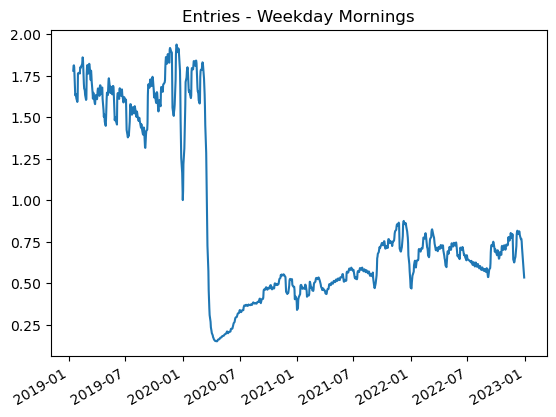

In [73]:
plt.plot(agg_ent["DATE"], agg_ent["rolling"])
plt.title("Entries - Weekday Mornings")
plt.gcf().autofmt_xdate();


In [74]:
# alt names

In [75]:
stationmap = {'1 AV - L': '1st Ave - L',
 '103 ST - 1': '103rd St - 1',
 '103 ST - 6': '103rd St - 4-6-6 Express',
 '103 ST - BC': '103rd St - A-B-C',
 '103 ST-CORONA - 7': '103rd St - Corona Plaza - 7',
 '104 ST - A': '104th St - A-S',
 '104 ST - JZ': '104th-102nd Sts - J-Z',
 '110 ST - 6': '110th St - 4-6-6 Express',
 '111 ST - 7': '111th St - 7',
 '111 ST - A': '111th St - A-S',
 '111 ST - J': '111th St - J',
 '116 ST - 23': '116th St - 2-3',
 '116 ST - 6': '116th St - 4-6-6 Express',
 '116 ST - BC': '116th St - A-B-C',
 '116 ST-COLUMBIA - 1': '116th St - Columbia University - 1',
 '121 ST - JZ': '121st St - J-Z',
 '125 ST - 1': '125th St - 1',
 '125 ST - 23': '125th St - 2-3',
 '125 ST - 456': '125th St - 4-5-6-6 Express',
 '125 ST - ACBD': '125th St - A-B-C-D',
 '135 ST - 23': '135th St - 2-3',
 '135 ST - BC': '135th St - A-B-C',
 '137 ST CITY COL - 1': '137th St - City College - 1',
 '138/GRAND CONC - 45': '138th St - Grand Concourse - 4-5',
 '14 ST - 123FLM': '14th St - F-M',
 '14 ST - ACEL': '14th St - A-C-E',
 '14 ST - FLM123': '14th St - F-M',
 '14 ST-UNION SQ - 456LNQRW': 'Union Sq - 14th St - 4-5-6-6 Express',
 '14 ST-UNION SQ - LNQR456W': 'Union Sq - 14th St - N-Q-R-W',
 '145 ST - 1': '145th St - 1',
 '145 ST - ABCD': '145th St - A-B-C-D',
 '149/GRAND CONC - 245': '149th St - Grand Concourse - 2-5',
 '14TH STREET - 1': '14th St - 1-2-3',
 '15 ST-PROSPECT - FG': '15th St - Prospect Park - F-G',
 '155 ST - BD': '155th St - B-D',
 '155th St - A-C': '155 ST - C',
 '155 ST - C': '155th St - A-C',
 '157 ST - 1': '157th St - 1',
 '161/YANKEE STAD - 4BD': '161st St - Yankee Stadium - 4',
 '161/YANKEE STAD - BD4': '161st St - Yankee Stadium - 4',
 '167 ST - 4': '167th St - 4',
 '168 ST - 1AC': '168th St - 1',
 '168 ST - AC1': '168th St - 1',
 '169 ST - F': '169th St - F',
 '170 ST - 4': '170th St - 4',
 '170 ST - BD': '170th St - B-D',
 '174 ST - 25': '174th St - 2-5',
 '175 ST - A': '175th St - A',
 '176 ST - 4': '176th St - 4',
 '18 AV - D': '18th Ave - D',
 '18 AV - F': '18th Ave - F',
 '18 AV - N': '18th Ave - N',
 '18 ST - 1': '18th St - 1-2',
 '181 ST - 1': '181st St - 1',
 '181 ST - A': '181st St - A',
 '182-183 STS - BD': '182nd-183rd Sts - B-D',
 '183 ST - 4': '183rd St - 4',
 '190 ST - A': '190th St - A',
 '191 ST - 1': '191st St - 1',
 '2 AV - F': 'Lower East Side - 2nd Ave - F',
 '20 AV - D': '20th Ave - D',
 '20 AV - N': '20th Ave - N',
 '207 ST - 1': '207th St - 1',
 '21 ST - G': '21st St - G',
 '21 ST-QNSBRIDGE - F': '21st St - Queensbridge - F',
 '215 ST - 1': '215th St - 1',
 '219 ST - 25': '219th St - 2-5',
 '225 ST - 25': '225th St - 2-5',
 '23 ST - 1': '23rd St - 1-2',
 '23 ST - 6': '23rd St - 4-6-6 Express',
 '23 ST - CE': '23rd St - A-C-E',
 '23 ST - NRW': '23rd St - N-Q-R-W',
 '231 ST - 1': '231st St - 1',
 '233 ST - 25': '233rd St - 2-5',
 '238 ST - 1': '238th St - 1',
 '25 AV - D': '25th Ave - D',
 '25 ST - R': '25th St - D-N-R',
 '28 ST - 1': '28th St - 1-2',
 '28 ST - NRW': '28th St - N-Q-R-W',
 '3 AV - L': '3rd Ave - L',
 '3 AV 138 ST - 6': '3rd Ave - 138th St - 6-6 Express',
 '3 AV-149 ST - 25': '3rd Ave - 149th St - 2-5',
 '30 AV - NQW': '30th Ave - N-W',
 '33 ST - 6': '33rd St - 4-6-6 Express',
 '33 ST-RAWSON ST - 7': '33rd St - 7',
 '34 ST-HERALD SQ - BDFMNQRW': 'Herald Sq - 34th St - B-D-F-M',
 '34 ST-HUDSON YD - 7': '34th St - Hudson Yards - 7-7 Express',
 '34 ST-PENN STA - 123': '34th St - Penn Station - 1-2-3',
 '34 ST-PENN STA - 123ACE': '34th St - Penn Station - A-C-E',
 '34 ST-PENN STA - ACE': '34th St - Penn Station - A-C-E',
 '36 AV - NQW': '36th Ave - N-W',
 '36 ST - DNR': '36th St - D-N-R',
 '36 ST - MR': '36th St - E-M-R',
 '4 AV-9 ST - DFGMNR': '4th Av - 9th St - D-N-R',
 '40 ST LOWERY ST - 7': '40th St - 7',
 '42 ST-BRYANT PK - BDFM7': '42nd St - Bryant Pk - B-D-F-M',
 '42 ST-PORT AUTH - ACENGRS1237W': '42nd St - Port Authority Bus Term - A-C-E',
 '42 ST-PORT AUTH - ACENQRS1237W': '42nd St - Port Authority Bus Term - A-C-E',
 '45 ST - R': '45th St - N-R',
 '46 ST - MR': '46th St - E-M-R',
 '46 ST BLISS ST - 7': '46th St - 7',
 '47-50 STS ROCK - BDFM': '47th-50th Sts - Rockefeller Ctr - B-D-F-M',
 '49 ST - NQRW': '49th St - N-Q-R-W',
 '4AV-9 ST - DFGMNR': '4th Av - 9th St - D-N-R',
 '5 AV/53 ST - EM': '5th Ave - 53rd St - E-M',
 '5 AV/59 ST - NQRW': '5th Ave - 59th St - N-R-W',
 '5 AVE - 7BDFM': '5th Ave - Bryant Pk - 7-7 Express',
 '50 ST - 1': '50th St - 1-2',
 '50 ST - CE': '50th St - A-C-E',
 '50 ST - D': '50th St - D',
 '51 ST - 6': '51st St - 4-6-6 Express',
 '52 ST - 7': '52nd St - 7',
 '53 ST - R': '53rd St - N-R',
 '55 ST - D': '55th St - D',
 '57 ST-7 AV - NQRW': '57th St - N-Q-R-W',
 '59 ST - 456NQRW': 'Lexington Ave - 59th St - 4-5-6-6 Express',
 '59 ST - NQR456W': '59th St - N-R',
 '59 ST - NRW': '59th St - N-R',
 '59 ST COLUMBUS - 1ABCD': '59th St - Columbus Circle - 1-2',
 '59 ST COLUMBUS - ABCD1': '59th St - Columbus Circle - A-B-C-D',
 '6 AV - FLM123': '6th Ave - L',
 '61 ST WOODSIDE - 7': 'Woodside - 61st St - 7-7 Express',
 '63 DR-REGO PARK - MR': '63rd Dr - Rego Park - E-M-R',
 '65 ST - MR': '65th St - E-M-R',
 '66 ST-LINCOLN - 1': '66th St - Lincoln Ctr - 1-2',
 '67 AV - MR': '67th Ave - E-M-R',
 '68ST-HUNTER CO - 6': '68th St - Hunter College - 4-6-6 Express',
 '69 ST - 7': '69th St - 7',
 '7 AV - BDE': '7th Ave - B-D-E',
 '7 AV - BQ': '7th Ave - B-Q',
 '7 AV - FG': '7th Ave - F-G',
 '71 ST - D': '71st St - D',
 '72 ST - 123': '72nd St - 1-2-3',
 '72 ST-2 AVE - Q': '72nd St - Q',
 '74 ST-BROADWAY - 7EFMR': '74th St - Broadway - 7',
 '75 AV - EF': '75th Ave - E-F',
 '75 ST-ELDERTS - JZ': '75th St - Eldert Ln - J-Z',
 '77 ST - 6': '77th St - 4-6-6 Express',
 '77 ST - R': '77th St - R',
 '79 ST - 1': '79th St - 1-2',
 '79 ST - D': '79th St - D',
 '8 AV - ACEL': '8th Ave - L',
 '8 AV - N': '8th St - NYU - N-Q-R-W',
 '8 ST-NYU - NRW': '8th St - NYU - N-Q-R-W',
 '80 ST - A': '80th St - A-S',
 '81 ST-MUSEUM - BC': '81st St - A-B-C',
 '82 ST-JACKSON H - 7': '82nd St - Jackson Hts - 7',
 '85 ST-FOREST PK - J': '85th St - Forest Pky - J',
 '86 ST - 1': '86th St - 1-2',
 '86 ST - 456': '86th St - 4-5-6-6 Express',
 '86 ST - N': '86th St - R',
 '86 ST - R': '86th St - R',
 '86 ST-2 AVE - Q': '86th St - Q',
 '88 ST - A': '88th St - A-S',
 '9 AV - D': '9th Ave - D',
 '90 ST-ELMHURST - 7': '90th St - Elmhurst Av - 7',
 '96 ST - 123': '96th St - 1-2-3',
 '96 ST - 6': '96th St - 4-6-6 Express',
 '96 ST - BC': '96th St - A-B-C',
 '96 ST-2 AVE - Q': '96th St - Q',
 'ALABAMA AV - J': 'Alabama Ave - J',
 'ALLERTON AV - 25': 'Allerton Ave - 2-5',
 'AQUEDUCT N.COND - A': 'Aqueduct - North Conduit Av - A',
 'AQUEDUCT RACETR - A': 'Aqueduct Racetrack - A',
 'ASTOR PL - 6': 'Astor Pl - 4-6-6 Express',
 'ASTORIA BLVD - NQW': 'Astoria Blvd - N-W',
 'ASTORIA DITMARS - NQW': 'Astoria - Ditmars Blvd - N-W',
 'ATL AV-BARCLAY - 2345BDNQR': "Atlantic Av - Barclay's Center - 2-3-4-5",
 'ATL AV-BARCLAY - BDNQR2345': "Atlantic Av - Barclay's Center - B-Q",
 'ATLANTIC AV - L': 'Atlantic Ave - L',
 'AVENUE H - BQ': 'Ave H - Q',
 'AVENUE I - F': 'Ave I - F',
 'AVENUE J - BQ': 'Ave J - Q',
 'AVENUE M - BQ': 'Ave M - Q',
 'AVENUE N - F': 'Ave N - F',
 'AVENUE P - F': 'Ave P - F',
 'AVENUE U - BQ': 'Ave U - Q',
 'AVENUE U - F': 'Ave U - F',
 'AVENUE U - N': 'Ave U - N',
 'AVENUE X - F': 'Ave X - F',
 "B'WAY-LAFAYETTE - BDFQ6": 'Broadway - Lafayette St - B-D-F-M',
 'BAY 50 ST - D': 'Bay 50th St - D',
 'BAY PKWY - D': 'Bay Pky - D',
 'BAY PKWY - F': 'Bay Pky - F',
 'BAY PKWY - N': 'Bay Pky - N',
 'BAY RIDGE AV - R': 'Bay Ridge Ave - R',
 'BAY RIDGE-95 ST - R': 'Bay Ridge - 95th St - R',
 'BAYCHESTER AV - 5': 'Baychester Ave - 5',
 'BEACH 105 ST - AS': 'Beach 105th St - A-S',
 'BEACH 25 ST - A': 'Beach 25th St - A',
 'BEACH 36 ST - A': 'Beach 36th St - A',
 'BEACH 44 ST - A': 'Beach 44th St - A',
 'BEACH 60 ST - A': 'Beach 60th St - A',
 'BEACH 67 ST - A': 'Beach 67th St - A',
 'BEACH 90 ST - AS': 'Beach 90th St - A-S',
 'BEACH 98 ST - AS': 'Beach 98th St - A-S',
 'BEDFORD AV - L': 'Bedford Ave - L',
 'BEDFORD PK BLVD - 4': 'Bedford Park Blvd - Lehman College - 4',
 'BEDFORD PK BLVD - BD': 'Bedford Park Blvd - B-D',
 'BEDFORD-NOSTRAN - G': 'Bedford - Nostrand Aves - G',
 'BERGEN ST - 23': 'Bergen St - 2-3-4',
 'BERGEN ST - FG': 'Bergen St - F-G',
 'BEVERLEY ROAD - BQ': 'Beverly Rd - Q',
 'BEVERLY RD - 25': 'Beverly Rd - 2-5',
 'BLEECKER ST - 6DF': 'Bleecker St - 4-6-6 Express',
 'BOROUGH HALL - 2345R': 'Borough Hall - 2-3',
 'BOROUGH HALL - R2345': 'Borough Hall - 4-5',
 'BOTANIC GARDEN - S2345': 'Botanic Garden - S',
 'BOWERY - JZ': 'Bowery - J-Z',
 'BOWLING GREEN - 45': 'Bowling Green - 4-5',
 'BRIARWOOD - EF': 'Briarwood - Van Wyck Blvd - E-F',
 'BRIGHTON BEACH - BQ': 'Brighton Beach - B-Q',
 'BROAD CHANNEL - AS': 'Broad Channel - A-S',
 'BROAD ST - JZ': 'Broad St - J-Z',
 'BROADWAY - G': 'Broadway - G',
 'BROADWAY JCT - ACJLZ': 'Broadway Junction - A-C',
 'BRONX PARK EAST - 25': 'Bronx Park East - 2-5',
 'BROOK AV - 6': 'Brook Ave - 6',
 'BROOKLYN BRIDGE - 456JZ': 'Brooklyn Bridge - City Hall - 4-5-6-6 Express',
 'BUHRE AV - 6': 'Buhre Ave - 6-6 Express',
 'BURKE AV - 25': 'Burke Ave - 2-5',
 'BURNSIDE AV - 4': 'Burnside Ave - 4',
 'BUSHWICK AV - L': 'Bushwick - Aberdeen - L',
 'CANAL ST - 1': 'Canal St - 1-2',
 'CANAL ST - ACE': 'Canal St - Holland Tunnel - A-C-E',
 'CANAL ST - JNQRZ6W': 'Canal St - 4-6-6 Express',
 'CANARSIE-ROCKAW - L': 'Canarsie - Rockaway Pkwy - L',
 'CARROLL ST - FG': 'Carroll St - F-G',
 'CASTLE HILL AV - 6': 'Castle Hill Ave - 6-6 Express',
 'CATHEDRAL PKWY - 1': 'Cathedral Pkwy (110th St) - 1',
 'CATHEDRAL PKWY - BC': 'Cathedral Pkwy (110th St) - A-B-C',
 'CENTRAL AV - M': 'Central Ave - M',
 'CENTRAL PK N110 - 23': 'Central Park North (110th St) - 2-3',
 'CHAMBERS ST - 123': 'Chambers St - 1-2-3',
 'CHAMBERS ST - ACE23': 'Chambers St - A-C',
 'CHAMBERS ST - JZ456': 'Chambers St - J-Z',
 'CHAUNCEY ST - JZ': 'Chauncey St - J-Z',
 'CHRISTOPHER ST - 1': 'Christopher St - Sheridan Sq - 1-2',
 'CHURCH AV - 25': 'Church Ave - 2-5',
 'CHURCH AV - BQ': 'Church Ave - B-Q',
 'CHURCH AV - FG': 'Church Ave - F-G',
 'CITY HALL - NRW': 'City Hall - R-W',
 'CLARK ST - 23': 'Clark St - 2-3',
 'CLASSON AV - G': 'Classon Ave - G',
 'CLEVELAND ST - J': 'Cleveland St - J',
 'CLINTON-WASH AV - C': 'Clinton - Washington Aves - A-C',
 'CLINTON-WASH AV - G': 'Clinton - Washington Aves - G',
 'CONEY IS-STILLW - DFNQ': 'Coney Island - Stillwell Av - D-F-N-Q',
 'CORTELYOU RD - BQ': 'Cortelyou Rd - Q',
 'CORTLANDT ST - 1': 'Cortlandt St - 1',
 'CORTLANDT ST - RNW': 'Cortlandt St - R-W',
 'COURT SQ - 7': 'Court Sq - 7-7 Express',
 'COURT SQ - EMG': 'Long Island City - Court Sq - G',
 'COURT SQ-23 ST - EMG': 'Court Sq - 23rd St - E-M',
 'CRESCENT ST - JZ': 'Crescent St - J-Z',
 'CROWN HTS-UTICA - 34': 'Crown Hts - Utica Ave - 3-4',
 'CYPRESS AV - 6': 'Cypress Ave - 6',
 'CYPRESS HILLS - J': 'Cypress Hills - J',
 'DEKALB AV - BDNQR': 'DeKalb Ave - B-D-N-Q-R',
 'DEKALB AV - L': 'DeKalb Ave - L',
 'DELANCEY/ESSEX - FJMZ': 'Delancey St - Essex St - F',
 'DITMAS AV - F': 'Ditmas Ave - F',
 'DYCKMAN ST - 1': 'Dyckman St - 1',
 'DYCKMAN ST - A': 'Dyckman St - A',
 "E 143/ST MARY'S - 6": "E 143rd St - St Mary's St - 6",
 'E 149 ST - 6': 'E 149th St - 6',
 'E 180 ST - 25': 'E 180th St - 2-5',
 'EAST 105 ST - L': 'E 105th St - L',
 'EAST BROADWAY - F': 'East Broadway - F',
 'EASTCHSTER/DYRE - 5': 'Eastchester - Dyre Ave - 5',
 'EASTN PKWY-MUSM - 23': 'Eastern Pkwy - Bklyn Museum - 2-3-4',
 'ELDER AV - 6': 'Elder Ave - 6',
 'ELMHURST AV - MR': 'Elmhurst Ave - E-M-R',
 'EUCLID AV - AC': 'Euclid Ave - A-C-S',
 'FAR ROCKAWAY - A': 'Far Rockaway - Mott Ave - A',
 'FLATBUSH AV-B.C - 25': 'Brooklyn College - Flatbush Ave - 2-5',
 'FLUSHING AV - G': 'Flushing Ave - G',
 'FLUSHING AV - JM': 'Flushing Ave - J-M',
 'FLUSHING-MAIN - 7': 'Flushing - Main St - 7-7 Express',
 'FORDHAM RD - 4': 'Fordham Rd - 4',
 'FORDHAM RD - BD': 'Fordham Rd - B-D',
 'FOREST AVE - M': 'Forest Ave - M',
 'FOREST HILLS 71 - EFMR': 'Forest Hills - 71st Av - E-F-M-R',
 'FRANKLIN AV - 2345S': 'Franklin Ave - 2-3-4-5',
 'FRANKLIN AV - ACS': 'Franklin Ave - A-C',
 'FRANKLIN ST - 1': 'Franklin St - 1-2',
 'FREEMAN ST - 25': 'Freeman St - 2-5',
 'FRESH POND RD - M': 'Fresh Pond Rd - M',
 'FT HAMILTON PKY - D': 'Ft Hamilton Pkwy - D',
 'FT HAMILTON PKY - FG': 'Ft Hamilton Pkwy - F-G',
 'FT HAMILTON PKY - N': 'Ft Hamilton Pkwy - N',
 'FULTON ST - 2345ACJZ': 'Fulton St - 2-3',
 'FULTON ST - ACJZ2345': 'Fulton St - 4-5',
 'FULTON ST - G': 'Fulton St - G',
 'GATES AV - JZ': 'Gates Ave - J-Z',
 'GRAHAM AV - L': 'Graham Ave - L',
 'GRAND ARMY PLAZ - 23': 'Grand Army Plaza - 2-3-4',
 'GRAND ST - BD': 'Grand St - B-D',
 'GRAND ST - L': 'Grand St - L',
 'GRAND-NEWTOWN - MR': 'Grand Ave - Newtown - E-M-R',
 'GRANT AV - A': 'Grant Ave - A-S',
 'GREENPOINT AV - G': 'Greenpoint Ave - G',
 'GRD CNTRL-42 ST - 4567S': 'Grand Central - 42nd St - 4-5-6-6 Express',
 'GUN HILL RD - 25': 'Gun Hill Rd - 2-5',
 'GUN HILL RD - 5': 'Gun Hill Rd - 5',
 'HALSEY ST - J': 'Halsey St - J',
 'HALSEY ST - L': 'Halsey St - L',
 'HARLEM 148 ST - 3': 'Harlem - 148 St - 3',
 'HEWES ST - JM': 'Hewes St - J-M',
 'HIGH ST - AC': 'High St - A-C',
 'HOUSTON ST - 1': 'Houston St - 1-2',
 'HOWARD BCH JFK - A': 'Howard Beach - JFK Airport - A',
 'HOYT ST - 23': 'Hoyt St - 2-3',
 'HOYT-SCHER - ACG': 'Hoyt - Schermerhorn Sts - A-C-G',
 'HUNTERS PT AV - 7': 'Hunters Point Ave - 7-7 Express',
 'HUNTS POINT AV - 6': 'Hunts Point Ave - 6-6 Express',
 'INTERVALE AV - 25': 'Intervale Ave - 2-5',
 'INWOOD-207 ST - A': 'Inwood - 207th St - A',
 'JACKSON AV - 25': 'Jackson Ave - 2-5',
 'JAMAICA 179 ST - F': 'Jamaica - 179th St - F',
 'JAMAICA CENTER - EJZ': 'Jamaica Ctr - Parsons / Archer - E-J-Z',
 'JAMAICA VAN WK - E': 'Jamaica - Van Wyck - E',
 'JAY ST-METROTEC - ACF': 'Jay St - MetroTech - A-C-F',
 'JAY ST-METROTEC - R': 'Jay St - MetroTech - N-R',
 'JEFFERSON ST - L': 'Jefferson St - L',
 'JFK JAMAICA CT1 - E': 'Jamaica - Van Wyck - E',
 'JKSN HT-ROOSVLT - EFMR7': 'Jackson Hts - Roosevelt Av - E-F-M-R',
 'JUNCTION BLVD - 7': 'Junction Blvd - 7-7 Express',
 'JUNIUS ST - 3': 'Junius St - 3-4',
 'KEW GARDENS - EF': 'Kew Gardens - Union Tpke - E-F',
 'KINGS HWY - BQ': 'Kings Hwy - B-Q',
 'KINGS HWY - F': 'Kings Hwy - F',
 'KINGS HWY - N': 'Kings Hwy - N',
 'KINGSBRIDGE RD - 4': 'Kingsbridge Rd - 4',
 'KINGSBRIDGE RD - BD': 'Kingsbridge Rd - B-D',
 'KINGSTON AV - 3': 'Kingston Ave - 3-4',
 'KINGSTON-THROOP - C': 'Kingston - Throop Aves - A-C',
 'KNICKERBOCKER - M': 'Knickerbocker Ave - M',
 'KOSCIUSZKO ST - J': 'Kosciuszko St - J',
 'LAFAYETTE AV - C': 'Lafayette Ave - A-C',
 'LEXINGTON AV/53 - EM6': 'Lexington Ave - 53rd St - E-M',
 'LEXINGTON AV/63 - F': 'Lexington Ave - 63rd St - F-Q',
 'LIBERTY AV - C': 'Liberty Ave - A-C',
 'LIVONIA AV - L': 'Livonia Ave - L',
 'LONGWOOD AV - 6': 'Longwood Ave - 6',
 'LORIMER ST - JM': 'Lorimer St - J-M',
 'LORIMER ST - LG': 'Lorimer St - L',
 'MARBLE HILL-225 - 1': 'Marble Hill - 225th St - 1',
 'MARCY AV - JMZ': 'Marcy Ave - J-M-Z',
 'METROPOLITAN AV - GL': 'Metropolitan Ave - G',
 'METROPOLITAN AV - M': 'Middle Village - Metropolitan Ave - M',
 'METS-WILLETS PT - 7': 'Mets - Willets Point - 7-7 Express',
 'MIDDLETOWN RD - 6': 'Middletown Rd - 6-6 Express',
 'MONTROSE AV - L': 'Montrose Ave - L',
 'MORGAN AV - L': 'Morgan Ave - L',
 'MORISN AV/SNDVW - 6': 'Morrison Av - Soundview - 6',
 'MORRIS PARK - 5': 'Morris Park - 5',
 'MOSHOLU PKWY - 4': 'Mosholu Pkwy - 4',
 'MT EDEN AV - 4': 'Mt Eden Ave - 4',
 'MYRTLE AV - JMZ': 'Myrtle Ave - J-M-Z',
 'MYRTLE-WILLOUGH - G': 'Myrtle-Willoughby Aves - G',
 'MYRTLE-WYCKOFF - LM': 'Myrtle - Wyckoff Aves - L',
 'NASSAU AV - G': 'Nassau Ave - G',
 'NECK RD - BQ': 'Neck Rd - Q',
 'NEPTUNE AV - F': 'Neptune Ave - F',
 'NEREID AV - 25': 'Nereid Ave (238 St) - 2-5',
 'NEVINS ST - 2345': 'Nevins St - 2-3-4-5',
 'NEW LOTS - L': 'New Lots Ave - L',
 'NEW LOTS AV - 3': 'New Lots Ave - 3-4',
 'NEW UTRECHT AV - ND': 'New Utrecht Ave - N',
 'NEWKIRK AV - 25': 'Newkirk Ave - 2-5',
 'NEWKIRK PLAZA - BQ': 'Newkirk Ave - B-Q',
 'NORTHERN BLVD - MR': 'Northern Blvd - E-M-R',
 'NORWOOD 205 ST - D': 'Norwood - 205th St - D',
 'NORWOOD AV - JZ': 'Norwood Ave - J-Z',
 'NOSTRAND AV - 3': 'Nostrand Ave - 3-4',
 'NOSTRAND AV - AC': 'Nostrand Ave - A-C',
 'OCEAN PKWY - Q': 'Ocean Pkwy - Q',
 'OZONE PK LEFFRT - A': 'Ozone Park - Lefferts Blvd - A-S',
 'PARK PLACE - 23ACE': 'Park Pl - 2-3',
 'PARK PLACE - S': 'Park Pl - S',
 'PARKCHESTER - 6': 'Parkchester - 6-6 Express',
 'PARKSIDE AV - BQ': 'Parkside Ave - Q',
 'PARSONS BLVD - F': 'Parsons Blvd - F',
 'PELHAM BAY PARK - 6': 'Pelham Bay Park - 6-6 Express',
 'PELHAM PKWY - 25': 'Pelham Pkwy - 2-5',
 'PELHAM PKWY - 5': 'Pelham Pkwy - 5',
 'PENNSYLVANIA AV - 3': 'Pennsylvania Ave - 3-4',
 'PRESIDENT ST - 25': 'President St - 2-5',
 'PRINCE ST - NRW': 'Prince St - N-Q-R-W',
 'PROSPECT AV - 25': 'Prospect Ave - 2-5',
 'PROSPECT AV - R': 'Prospect Ave - D-N-R',
 'PROSPECT PARK - BQS': 'Prospect Park - B-Q-S',
 'QUEENS PLAZA - EMR': 'Queens Plz - E-M-R',
 'QUEENSBORO PLZ - 7NQW': 'Queensboro Plz - 7-7 Express-N-W',
 'RALPH AV - C': 'Ralph Ave - A-C',
 'RECTOR ST - 1': 'Rector St - 1',
 'RECTOR ST - NRW': 'Rector St - R-W',
 'RIT-ROOSEVELT - R': 'Jackson Hts - Roosevelt Av - E-F-M-R',
 'ROCKAWAY AV - 3': 'Rockaway Ave - 3-4',
 'ROCKAWAY AV - C': 'Rockaway Ave - A-C',
 'ROCKAWAY BLVD - A': 'Rockaway Blvd - A-S',
 'ROCKAWAY PARK B - AS': 'Rockaway Park - Beach 116 St - A-S',
 'ROOSEVELT ISLND - F': 'Roosevelt Island - Main St - F',
 'SARATOGA AV - 3': 'Saratoga Ave - 3-4',
 'SENECA AVE - M': 'Seneca Ave - M',
 'SHEEPSHEAD BAY - BQ': 'Sheepshead Bay - B-Q',
 'SHEPHERD AV - C': 'Shepherd Ave - A-C',
 'SIMPSON ST - 25': 'Simpson St - 2-5',
 'SMITH-9 ST - FG': 'Smith - 9th Sts - F-G',
 'SOUTH FERRY - 1RW': 'South Ferry - 1',
 'SPRING ST - 6': 'Spring St - 4-6-6 Express',
 'SPRING ST - CE': 'Spring St - A-C-E',
 'ST LAWRENCE AV - 6': 'St Lawrence Ave - 6',
 'STEINWAY ST - MR': 'Steinway St - E-M-R',
 'STERLING ST - 25': 'Sterling St - 2-5',
 'SUTPHIN BLVD - F': 'Sutphin Blvd - F',
 'SUTPHIN-ARCHER - EJZ': 'Sutphin Blvd - Archer Av - E-J-Z',
 'SUTTER AV - L': 'Sutter Ave - L',
 'SUTTER AV-RUTLD - 3': 'Sutter Ave - Rutland Road - 3-4',
 'TIMES SQ-42 ST - 1237ACENQRS': 'Times Sq - 42nd St - 1-2-3',
 'TIMES SQ-42 ST - 1237ACENQRSW': 'Times Sq - 42nd St - 7-7 Express',
 'TIMES SQ-42 ST - ACENQRS1237W': 'Times Sq - 42nd St - N-Q-R-W',
 'TREMONT AV - BD': 'Tremont Ave - B-D',
 'TWENTY THIRD ST - 1': '23rd St - 1-2',
 'UNION ST - R': 'Union St - D-N-R',
 'UTICA AV - AC': 'Utica Ave - A-C',
 'V.CORTLANDT PK - 1': 'Van Cortlandt Park - 242nd St - 1',
 'VAN SICLEN AV - 3': 'Van Siclen Ave - 3-4',
 'VAN SICLEN AV - JZ': 'Van Siclen Ave - J-Z',
 'VAN SICLEN AVE - C': 'Van Siclen Ave - A-C',
 'VERNON-JACKSON - 7': 'Vernon Blvd - Jackson Ave - 7-7 Express',
 'W 4 ST-WASH SQ - ABCDEFM': 'W 4th St - Washington Sq (Lower) - B-D-F-M',
 'W 8 ST-AQUARIUM - FQ': 'W 8th St - NY Aquarium - F-Q',
 'WAKEFIELD/241 - 2': 'Wakefield - 241st St - 2',
 'WALL ST - 23': 'Wall St - 2-3',
 'WALL ST - 45': 'Wall St - 4-5',
 'WEST FARMS SQ - 25': 'West Farms Sq - E Tremont Av - 2-5',
 'WESTCHESTER SQ - 6': 'Westchester Sq - E Tremont Ave - 6-6 Express',
 'WHITEHALL S-FRY - R1W': 'Whitehall St - R-W',
 'WHITLOCK AV - 6': 'Whitlock Ave - 6',
 'WILSON AV - L': 'Wilson Ave - L',
 'WINTHROP ST - 25': 'Winthrop St - 2-5',
 'WOODHAVEN BLVD - JZ': 'Woodhaven Blvd - J-Z',
 'WOODHAVEN BLVD - MR': 'Woodhaven Blvd - Queens Mall - E-M-R',
 'WOODLAWN - 4': 'Woodlawn - 4',
 'WORLD TRADE CTR - ACE23': 'World Trade Center - E',
 'YORK ST - F': 'York St - F',
 'ZEREGA AV - 6': 'Zerega Ave - 6-6 Express',
 'ORCHARD BEACH - 6': '',
 'NEWARK HW BMEBE - 1': '',
 'HARRISON - 1': '',
 'JOURNAL SQUARE - 1': '',
 'GROVE STREET - 1': '',
 'EXCHANGE PLACE - 1': '',
 'PAVONIA/NEWPORT - 1': '',
 'CITY / BUS - 1': '',
 '9TH STREET - 1': '',
 'THIRTY ST - 1': '',
 'LACKAWANNA - 1': '',
 'THIRTY THIRD ST - 1': '',
 'NEWARK BM BW - 1': '',
 'NEWARK C - 1': '',
 'NEWARK HM HE - 1': '',
 'PATH WTC 2 - 1': '',
 'PATH NEW WTC - 1': '',
 'ST. GEORGE - 1': '',
 'TOMPKINSVILLE - 1': ''}
stationmap

{'1 AV - L': '1st Ave - L',
 '103 ST - 1': '103rd St - 1',
 '103 ST - 6': '103rd St - 4-6-6 Express',
 '103 ST - BC': '103rd St - A-B-C',
 '103 ST-CORONA - 7': '103rd St - Corona Plaza - 7',
 '104 ST - A': '104th St - A-S',
 '104 ST - JZ': '104th-102nd Sts - J-Z',
 '110 ST - 6': '110th St - 4-6-6 Express',
 '111 ST - 7': '111th St - 7',
 '111 ST - A': '111th St - A-S',
 '111 ST - J': '111th St - J',
 '116 ST - 23': '116th St - 2-3',
 '116 ST - 6': '116th St - 4-6-6 Express',
 '116 ST - BC': '116th St - A-B-C',
 '116 ST-COLUMBIA - 1': '116th St - Columbia University - 1',
 '121 ST - JZ': '121st St - J-Z',
 '125 ST - 1': '125th St - 1',
 '125 ST - 23': '125th St - 2-3',
 '125 ST - 456': '125th St - 4-5-6-6 Express',
 '125 ST - ACBD': '125th St - A-B-C-D',
 '135 ST - 23': '135th St - 2-3',
 '135 ST - BC': '135th St - A-B-C',
 '137 ST CITY COL - 1': '137th St - City College - 1',
 '138/GRAND CONC - 45': '138th St - Grand Concourse - 4-5',
 '14 ST - 123FLM': '14th St - F-M',
 '14 ST - ACEL'

In [76]:
print ("%s all done!" % (strftime("%H:%M:%S")))


15:40:34 all done!
